In [19]:
# Load the sentiment analysis dataset
from datasets import load_dataset, Dataset, DatasetDict
dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")

In [20]:
from transformers import AutoTokenizer

# Load GPT-2 tokenizer
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the data
def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )
    tokenized["labels"] = examples["label"]  # Add labels to the tokenized dataset
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)

In [3]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 45615
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 12284
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [4]:
from transformers import AutoModelForSequenceClassification

import torch

# Set the device to MPS explicitly
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# Load GPT-2 with a classification head
model = AutoModelForSequenceClassification.from_pretrained("gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)

In [5]:
from peft import get_peft_model, AdaLoraConfig
ada_lora_config = AdaLoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, ada_lora_config)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/peft/tuners/adalora/model.py:205: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [6]:
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch (to match evaluation strategy)
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust batch size if necessary
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

/Users/srinathsureshkumar/miniconda3/envs/bda/lib/python3.12/site-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/_v/9p5rkkbj79d0bmthxllw7rqm0000gn/T/ipykernel_65459/3537546471.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [7]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

  0%|          | 0/384 [00:00<?, ?it/s]

Tweet Accuracy: 0.4803809833930316
Tweet Precision: 0.28009475437590453
Tweet Recall: 0.3319848781813822
Tweet F1 Score: 0.21886813306947397
Tweet Accuracy: 0.4803809833930316


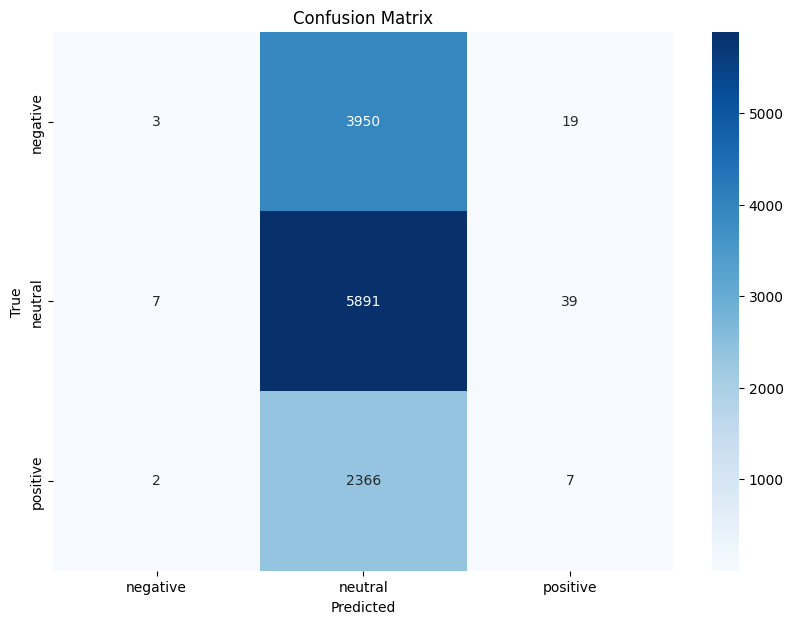

In [8]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [9]:
trainer.train()

  0%|          | 0/8553 [00:00<?, ?it/s]

{'loss': 5.2203, 'grad_norm': 25.406179428100586, 'learning_rate': 5e-05, 'epoch': 0.18}
{'loss': 2.0936, 'grad_norm': 59.641170501708984, 'learning_rate': 4.689556686948963e-05, 'epoch': 0.35}
{'loss': 1.9561, 'grad_norm': 31.31197738647461, 'learning_rate': 4.379113373897926e-05, 'epoch': 0.53}
{'loss': 1.8738, 'grad_norm': 27.292633056640625, 'learning_rate': 4.06867006084689e-05, 'epoch': 0.7}
{'loss': 1.7816, 'grad_norm': 147.713134765625, 'learning_rate': 3.7582267477958524e-05, 'epoch': 0.88}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.8609729409217834, 'eval_model_preparation_time': 0.002, 'eval_runtime': 24.563, 'eval_samples_per_second': 81.423, 'eval_steps_per_second': 2.565, 'epoch': 1.0}
{'loss': 1.7323, 'grad_norm': 140.3459930419922, 'learning_rate': 3.4477834347448155e-05, 'epoch': 1.05}
{'loss': 1.6664, 'grad_norm': 57.88718032836914, 'learning_rate': 3.1373401216937785e-05, 'epoch': 1.23}
{'loss': 1.5958, 'grad_norm': 80.60307312011719, 'learning_rate': 2.8268968086427423e-05, 'epoch': 1.4}
{'loss': 1.5152, 'grad_norm': 50.65568923950195, 'learning_rate': 2.5164534955917053e-05, 'epoch': 1.58}
{'loss': 1.4771, 'grad_norm': 117.50015258789062, 'learning_rate': 2.206010182540668e-05, 'epoch': 1.75}
{'loss': 1.5001, 'grad_norm': 125.37301635742188, 'learning_rate': 1.8955668694896314e-05, 'epoch': 1.93}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.7286390662193298, 'eval_model_preparation_time': 0.002, 'eval_runtime': 25.2857, 'eval_samples_per_second': 79.096, 'eval_steps_per_second': 2.492, 'epoch': 2.0}
{'loss': 1.4836, 'grad_norm': 25.9930419921875, 'learning_rate': 1.5851235564385944e-05, 'epoch': 2.1}
{'loss': 1.465, 'grad_norm': 80.6674575805664, 'learning_rate': 1.2746802433875573e-05, 'epoch': 2.28}
{'loss': 1.4607, 'grad_norm': 45.155765533447266, 'learning_rate': 9.642369303365207e-06, 'epoch': 2.46}
{'loss': 1.4162, 'grad_norm': 97.15199279785156, 'learning_rate': 6.5379361728548376e-06, 'epoch': 2.63}
{'loss': 1.4414, 'grad_norm': 42.434757232666016, 'learning_rate': 3.433503042344468e-06, 'epoch': 2.81}
{'loss': 1.4332, 'grad_norm': 27.10915184020996, 'learning_rate': 3.290699118340991e-07, 'epoch': 2.98}


  0%|          | 0/63 [00:00<?, ?it/s]

{'eval_loss': 0.7134867906570435, 'eval_model_preparation_time': 0.002, 'eval_runtime': 24.3051, 'eval_samples_per_second': 82.287, 'eval_steps_per_second': 2.592, 'epoch': 3.0}
{'train_runtime': 4817.006, 'train_samples_per_second': 28.409, 'train_steps_per_second': 1.776, 'train_loss': 1.827944452826996, 'epoch': 3.0}


TrainOutput(global_step=8553, training_loss=1.827944452826996, metrics={'train_runtime': 4817.006, 'train_samples_per_second': 28.409, 'train_steps_per_second': 1.776, 'total_flos': 9067512214932480.0, 'train_loss': 1.827944452826996, 'epoch': 3.0})

In [18]:


# Save the fine-tuned model
model.save_pretrained("./ada-lora-sentiment-gpt2.2")
tokenizer.save_pretrained("./ada-lora-sentiment-gpt2.2")

('./ada-lora-sentiment-gpt2.2/tokenizer_config.json',
 './ada-lora-sentiment-gpt2.2/special_tokens_map.json',
 './ada-lora-sentiment-gpt2.2/vocab.json',
 './ada-lora-sentiment-gpt2.2/merges.txt',
 './ada-lora-sentiment-gpt2.2/added_tokens.json',
 './ada-lora-sentiment-gpt2.2/tokenizer.json')

  0%|          | 0/384 [00:00<?, ?it/s]

Tweet Accuracy: 0.6678606317160534
Tweet Precision: 0.6582116348554389
Tweet Recall: 0.6728746125228486
Tweet F1 Score: 0.6644129716592913
Tweet Accuracy: 0.6678606317160534


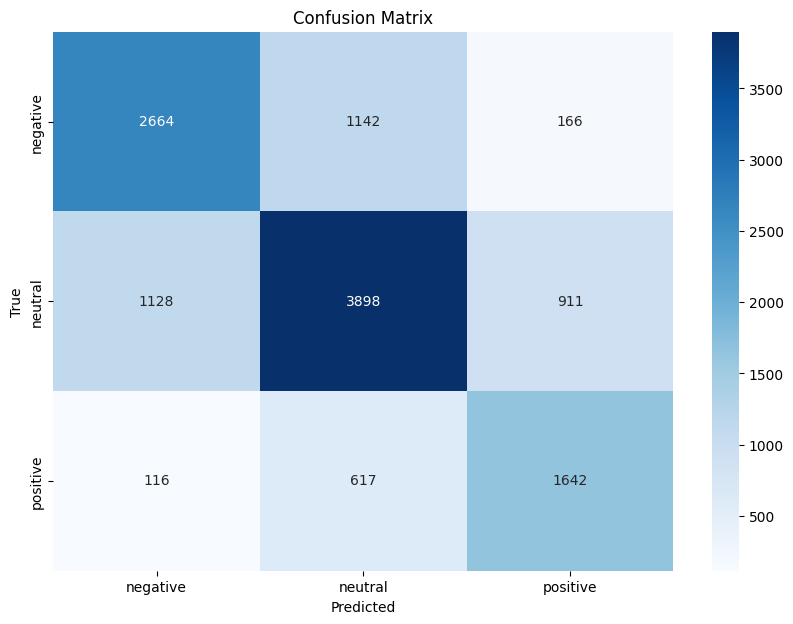

In [21]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
dataset = load_dataset("cardiffnlp/super_tweeteval", "tweet_sentiment")
label_mapping = {0: 0, 1: 0, 2: 1, 3: 2, 4: 2}  

def replace_labels(examples, label_mapping):
    examples['label'] = [label_mapping[label] for label in examples['gold_label']]
    return examples

# Replace labels in the dataset using the mapping
dataset = dataset.map(lambda examples: replace_labels(examples, label_mapping), batched=True)


In [ ]:

tokenizer = AutoTokenizer.from_pretrained("./ada-sentiment-gpt2")
tokenizer.pad_token = tokenizer.eos_token


def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["labels"] = examples["label"]  
    return tokenized

tokenized_datasets = dataset.map(preprocess_function, batched=True)
reddit_tokenized_datasets = reddit_dataset.map(preprocess_function, batched=True)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./sentiment-gpt2", num_labels=3) 
model.config.pad_token_id = tokenizer.pad_token_id
model.to(device)

In [ ]:
from peft import get_peft_model, AdaLoraConfig
ada_lora_config = LoraConfig(
    task_type="SEQ_CLS",
    r=8,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, ada_lora_config)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Evaluate the model at the end of each epoch
    save_strategy="epoch",  # Save the model at the end of each epoch (to match evaluation strategy)
    learning_rate=5e-5,
    per_device_train_batch_size=8,  # Adjust batch size if necessary
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    warmup_steps=500,
    logging_dir="./logs",
    save_total_limit=2,
    gradient_accumulation_steps=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

In [ ]:
trainer.train()

In [ ]:
# Evaluate the model
results = trainer.evaluate(tokenized_datasets["test"])
print(results)

# Save the fine-tuned model
model.save_pretrained("./ada-lora-sentiment-gpt2-2")
tokenizer.save_pretrained("./ada-lora-sentiment-gpt2-2")

In [ ]:
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Map:   0%|          | 0/5246 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Map:   0%|          | 0/1749 [00:00<?, ? examples/s]

Tweet Accuracy: 0.544882790165809
Tweet Precision: 0.6280097953333125
Tweet Recall: 0.5631667415501194
Tweet F1 Score: 0.5532604761528993
Tweet Accuracy: 0.544882790165809


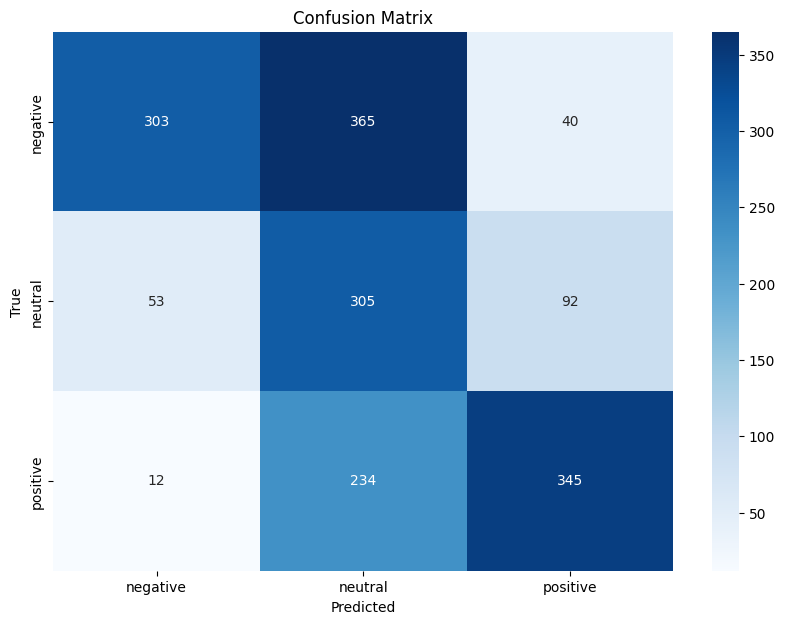

In [15]:



from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('all_sampled_twitter.csv')

# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)


train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Create a DatasetDict
dataset = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
tokenized_datasets = dataset.map(preprocess_function, batched=True)
predictions = trainer.predict(tokenized_datasets['test'])
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), dim=1)

accuracy = accuracy_score(tokenized_datasets['test']['label'], predicted_labels)
precision = precision_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
recall = recall_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')
f1_score_ = f1_score(tokenized_datasets['test']['label'], predicted_labels, average='macro')

print(f'Tweet Accuracy: {accuracy}')
print(f'Tweet Precision: {precision}')
print(f'Tweet Recall: {recall}')
print(f'Tweet F1 Score: {f1_score_}')
print(f'Tweet Accuracy: {accuracy}')

conf_matrix = confusion_matrix(tokenized_datasets['test']['labels'], predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['negative', 'neutral', 'positive'], yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()